# Model Analysis
## Case 1: Liquid Level in Tanks
### Author: Bernt Lie, University of South-Eastern Norway
### Date: March 22, 2023
### Installing packages

In [1]:
using ModelingToolkit
using ModelingToolkit: inputs, outputs
#using ModelingToolkitStandardLibrary
using DifferentialEquations
using Plots, LaTeXStrings
using ControlSystems, ControlSystemsMTK
using LinearAlgebra
#using Latexify

### Constants

In [2]:
# Specifying line properties as constants makes it possible to globally 
# change these values and keep consistency
LW1 = 2.5
LW2 = 2
LC1 = :red
LC2 = :blue
LC3 = :green
LC4 = :orange
LS1 = :solid
LS2 = :dash
LS3 = :dashdot
LS4 = :dot
LA1 = 1
LA2 = 0.3

figpath = "C:/Users/Bernt/OneDrive/Documents/booksBLSOL/ModDynSyst/figs/"
figtype = ".svg"
SAVEFIG = true
;

### Utility functions

In [3]:
function get_symbols(eqs)
    symbs = [reduce(vcat,[Symbolics.get_variables.(eq.lhs) for eq in eqs]); 
        reduce(vcat,[Symbolics.get_variables.(eq.rhs) for eq in eqs])]
    idxs_params = isequal.(expand_derivatives.(Differential(t).(symbs)),0)
    params = unique(symbs[idxs_params])
    vars = unique(symbs[isequal.(idxs_params,0)])
    return vars, params
end
;

In [4]:
function linearize_symbolic_dae01(eqs, u_mod, y_mod; x_opt = [])
    #
    # This function assumes that `eqs` represents an index 1 DAE 
    #
    # eqs: Symbolics partial model equations, i.e., with inputs undefined
    # u_mod: vector of variables which are inputs in `eqs`
    # y_mod: vector of variables in `eqs` which are outputs (inputs not allowed)
    # x_opt: optional state vector ξ if other than differential variables x
    #
    # Unknown dependent variables v 
    vars,_ = get_symbols(eqs)
    n_v = length(vars)
    #
    # Equations eqs split up into lhs and rhs
    eqs_lhs = [eq.lhs for eq in eqs]
    eqs_rhs = [eq.rhs for eq in eqs]
    n_eqs = length(eqs)
    # -- getting vec_field to be of correct size and type
    vec_field = eqs_rhs
    #
    # Determining which equations are differential, and which are algebraic
    # -- vector of derivatives; used for finding differential variables
    dvdt_mod = Differential(t).(vars)
    # -- assuming that only eqs_lhs has time derivatives of variables
    idxs_eq_d = filter(!isnothing,[findfirst(isequal.(eq,dvdt_mod)) for eq in eqs_lhs])
    idxs_eq_a = setdiff(1:n_eqs,idxs_eq_d)
    #
    # Finishing up vec_field
    vec_field[idxs_eq_d] .= eqs_rhs[idxs_eq_d]
    vec_field[idxs_eq_a] .= eqs_rhs[idxs_eq_a] .- eqs_lhs[idxs_eq_a]
    #
    # Finding Jacobian
    J = Symbolics.jacobian(vec_field,vars)
    #
    # Finding vars indices of inputs, differential variables, algebraic variables, outputs
    idxs_u = [findmax(isequal.(u,vars))[2] for u in u_mod]
    # -- differential and algebraic variables
    idxs_x = filter(!isnothing,[findfirst(isequal.(dvdt_mod,eq)) for eq in eqs_lhs])
    idxs_z = setdiff(1:n_v, idxs_u, idxs_x)
    # -- checking that inputs are not differential variables
    if !isdisjoint(idxs_x,idxs_u)
        println("Inputs can not be differential variables.")
        println("Inputs: $(u_mod)")
        println("Differential variables: $(v_mod[idxs_x])")
    end
    # -- outputs
    idxs_y = [findmax(isequal.(y,vars))[2] for y in y_mod]
    # -- checking that outputs are not inputs
    if !isdisjoint(idxs_y,idxs_u)
        println("Outputs can not be inputs.")
        println("Outputs: $(y_mod)")
        println("Inputs: $(u_mod)")
    end
    #
    # Deconstructing Jacobian
    J_d_x = J[idxs_eq_d,idxs_x]
    J_d_z = J[idxs_eq_d,idxs_z]
    J_d_u = J[idxs_eq_d,idxs_u]
    J_a_x = J[idxs_eq_a,idxs_x]
    J_a_z = J[idxs_eq_a,idxs_z]
    J_a_u = J[idxs_eq_a,idxs_u]
    #
    # Jacobian matrix for outputs; contains ones and zeros
    n_y = length(idxs_y)
    J_y = zeros(n_y,n_v)
    for i in 1:n_y
        J_y[i,:] = isequal.(y_mod[i],vars)
    end
    J_y_x = J_y[:,idxs_x]
    J_y_z = J_y[:,idxs_z]
    J_y_u = J_y[:,idxs_u]
    #
    # Finding LTI Matrices assuming differential variables are states
    # -- A and B matrices
    AA = simplify.(J_d_x - J_d_z*(J_a_z\J_a_x))
    BB = simplify.(J_d_u - J_d_z*(J_a_z\J_a_u))
    # -- C and D matrices
    CC = simplify.(J_y_x - J_y_z*(J_a_z\J_a_x))
    DD = simplify.(J_y_u - J_y_z*(J_a_z\J_a_u))
    #
    #-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
    # Checking whether optional states are requested
    #-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
    n_x = length(idxs_x)
    n_ξ = length(x_opt)
    #
    if n_ξ == 0
        return AA, BB, CC, DD, vars[idxs_x]
    elseif n_ξ != n_x
        println("Incorrect size of optional state")
        return AA, BB, CC, DD, vars[idxs_x]
    else
        # Finding transformation matrix TT from original to new state
        # -- indices for new state
        idxs_ξ = [findmax(isequal.(x,vars))[2] for x in x_opt]
        # Jacobian matrix for new state; contains ones and zeros
        J_ξ = zeros(n_ξ,n_v)
        for i in 1:n_ξ
            J_ξ[i,:] = isequal.(x_opt[i],vars)
        end
        J_ξ_x = J_ξ[:,idxs_x]
        J_ξ_z = J_ξ[:,idxs_z]
        J_ξ_u = J_ξ[:,idxs_u]
        #
        TT = simplify.(J_ξ_x - J_ξ_z*(J_a_z\J_a_x))
        TT_u = simplify.(J_ξ_u - J_ξ_z*(J_a_z\J_a_u))
        # -- not allowed to have inputs in ξ, i.e., must require TT_u ≡ 0
        if sum(isequal.(isequal.(TT_u,0),0)) != 0
            println("Optional states lead to input derivatives")
            return AA, BB, CC, DD, vars[idxs_x]
        end
        AA_ = simplify.(TT*AA*inv(TT))
        BB_ = simplify.(TT*BB)
        CC_ = simplify.(CC*inv(TT))
        DD_ = DD
        #
        return AA_, BB_, CC_, DD_, x_opt
    end
end
;

## Constant area tank with influent
When the model has an influent, it will not become empty, so there is little chance of the level $h$ to become negative by numerical error. Because of this, we can now use the simple expression for effluent.

### Input functions

We will use two input functions: one with constant value of 2, `ṁ_const(t)`, and one which starts at value 2 and then jumps down to value 1.5 at time = 1, `ṁ_step(t)`. The actual influent function is denoted `ṁ(t)`, and we set `ṁ(t)` equal to one of `ṁ_const(t)` and `ṁ_step(t)`.

In [5]:
ṁ_const(t) = 2
ṁ_step(t) = t < 1 ? 2 : 1.5    # meaning: if t < 1, then 2, else 1.5
;

### Constant influent
We create a function `ṁ(t)`which equals `ṁ_const(t)`:

In [6]:
ṁ(t) = ṁ_const(t);

Because function `ṁ(t)` is unknown to `ModelingToolkit.jl`, it must be *registered* (standard built-in Julia functions are by default registered) before we can use it:

In [7]:
@register_symbolic ṁ(t)

### Model

We now create the model with influent `ṁ_i` which we will set equal to function `ṁ`:

In [8]:
@parameters ρ=1 A=5 K=5 h_ς=3
@variables t m(t)=1.5*ρ*A ṁ_i(t) ṁ_e(t) V(t) h(t)
Dt = Differential(t)

eqs_p = [Dt(m) ~ ṁ_i-ṁ_e,
        m ~ ρ*V,
        V ~ A*h,
        ṁ_e ~ K*sqrt(h/h_ς)]

@named tank_p = ODESystem(eqs_p)    # Partial tank model, i.e., without inputs

eqs_i = [ṁ_i ~ ṁ(t)]
@named tank_i = ODESystem(eqs_i)

tank = extend(tank_i, tank_p)

Model tank_i with 5 equations
States (5):
  m(t) [defaults to 1.5A*ρ]
  ṁ_e(t)
  ṁ_i(t)
  V(t)
⋮
Parameters (4):
  ρ [defaults to 1]
  A [defaults to 5]
  h_ς [defaults to 3]
  K [defaults to 5]

In [9]:
tank_simp = structural_simplify(tank)

Model tank_i with 1 equations
States (1):
  m(t) [defaults to 1.5A*ρ]
Parameters (4):
  ρ [defaults to 1]
  A [defaults to 5]
  h_ς [defaults to 3]
  K [defaults to 5]
Incidence matrix:1×2 SparseArrays.SparseMatrixCSC{Num, Int64} with 2 stored entries:
 ×  ×

In [10]:
full_equations(tank_simp)

1-element Vector{Equation}:
 Differential(t)(m(t)) ~ ṁ(t) - K*sqrt(m(t) / (A*h_ς*ρ))

### Running simulation to find (numeric) steady state

In [11]:
tspan = (0.0,1e3)

prob = ODEProblem(tank_simp, [], tspan)
sol = solve(prob)
name_s = states(tank)
s_ss = sol(tspan[2]; idxs = name_s)
m_ss = sol(tspan[2]; idxs = m)
h_ss = sol(tspan[2]; idxs = h)
;

### Symbolic linearization of model
#### Default state

In [12]:
tank_p

Model tank_p with 4 equations
States (5):
  m(t) [defaults to 1.5A*ρ]
  ṁ_e(t)
  ṁ_i(t)
  V(t)
⋮
Parameters (4):
  ρ [defaults to 1]
  A [defaults to 5]
  h_ς [defaults to 3]
  K [defaults to 5]

In [13]:
states(tank_p)

5-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 m(t)
 ṁ_e(t)
 ṁ_i(t)
 V(t)
 h(t)

In [14]:
u_tank = [ṁ_i]
y_tank = [h]
x_tank = [h]

As, Bs, Cs, Ds, x_name = linearize_symbolic_dae01(eqs_p, u_tank, y_tank)
x_name

1-element Vector{Any}:
 m(t)

In [15]:
As

1×1 Matrix{Num}:
 (-K) / (2A*h_ς*ρ*sqrt(h(t) / h_ς))

In [16]:
Bs

1×1 Matrix{Num}:
 1.0

In [17]:
Cs

1×1 Matrix{Num}:
 1 / (A*ρ)

In [18]:
Ds

1×1 Matrix{Num}:
 0.0

#### Specified state

In [19]:
A1s, B1s, C1s, D1s, x_name = linearize_symbolic_dae01(eqs_p, u_tank, y_tank, x_opt=x_tank)
x_name

1-element Vector{Num}:
 h(t)

In [20]:
A1s

1×1 Matrix{Num}:
 (-K) / (2A*h_ς*ρ*sqrt(h(t) / h_ς))

In [21]:
B1s

1×1 Matrix{Num}:
 1 / (A*ρ)

In [22]:
C1s

1×1 Matrix{Num}:
 1

In [23]:
D1s

1×1 Matrix{Num}:
 0.0

### Numeric evaluation of symbolically linearized model
#### Default state

In [24]:
default_vals = ModelingToolkit.defaults(tank_p)

Dict{Any, Any} with 5 entries:
  h_ς  => 3
  K    => 5
  m(t) => 1.5A*ρ
  A    => 5
  ρ    => 1

In [25]:
name_s

5-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 m(t)
 ṁ_e(t)
 ṁ_i(t)
 V(t)
 h(t)

In [26]:
Asn = substitute(As, Dict(name_s .=> s_ss)) |> x -> substitute(x, default_vals) |> x -> Symbolics.unwrap.(x)

1×1 Matrix{Float64}:
 -0.4166666666386296

In [27]:
Bsn = substitute(Bs, Dict(name_s .=> s_ss)) |> x -> substitute(x, default_vals) |> x -> Symbolics.unwrap.(x)

1×1 Matrix{Float64}:
 1.0

In [28]:
Csn = substitute(Cs, default_vals) |> x -> Symbolics.unwrap.(x)

1×1 Matrix{Float64}:
 0.2

In [29]:
Dsn = substitute(Ds, default_vals) |> x -> Symbolics.unwrap.(x)

1×1 Matrix{Float64}:
 0.0

#### Specified state

In [30]:
A1sn = substitute(A1s, Dict(name_s .=> s_ss)) |> x -> substitute(x, default_vals) |> x -> Symbolics.unwrap.(x)

1×1 Matrix{Float64}:
 -0.4166666666386296

In [31]:
B1sn = substitute(B1s, Dict(name_s .=> s_ss)) |> x -> substitute(x, default_vals) |> x -> Symbolics.unwrap.(x)

1×1 Matrix{Float64}:
 0.2

In [32]:
C1sn = substitute(C1s, Dict(name_s .=> s_ss)) |> x -> substitute(x, default_vals) |> x -> Symbolics.unwrap.(x)

1×1 Matrix{Int64}:
 1

In [33]:
D1sn = substitute(D1s, Dict(name_s .=> s_ss)) |> x -> substitute(x, default_vals) |> x -> Symbolics.unwrap.(x)

1×1 Matrix{Float64}:
 0.0

### Transfer Functions

In [34]:
sys_sn = ss(Asn,Bsn,Csn,Dsn) |> tf

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
   0.19999999999999996
-------------------------
1.0s + 0.4166666666386296

Continuous-time transfer function model

In [35]:
sys1_sn = ss(A1sn,B1sn,C1sn,D1sn) |> tf

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
   0.19999999999999996
-------------------------
1.0s + 0.4166666666386296

Continuous-time transfer function model

### Time constant from symbolic expression

In [36]:
τ = -1/A1s[]

(2A*h_ς*ρ*sqrt(h(t) / h_ς)) / K

In [37]:
substitute(τ, Dict(name_s .=> s_ss)) |> x -> substitute(x, default_vals) |> x -> Symbolics.unwrap.(x)

2.4000000001614934

### Linearizing the model using MTK

In [38]:
mats, tank_ = linearize(tank_p, [ṁ_i], [h], op=Dict(m=>m_ss, ṁ_i=>ṁ(0)))
sys = ss(mats...)

StateSpace{Continuous, Float64}
A = 
 -0.4166666666386296
B = 
 1.0
C = 
 0.2
D = 
 -0.0

Continuous-time state-space model

In [39]:
[states(tank_); inputs(tank_); outputs(tank_)]

3-element Vector{Any}:
 m(t)
 ṁ_i(t)
 h(t)

In [40]:
tf(sys)

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
   0.19999999999999996
-------------------------
1.0s + 0.4166666666386296

Continuous-time transfer function model

### Linearization using ControlSystemsMTK

In [41]:
named_ss(tank_p, [ṁ_i], [h]; op=Dict(m=>m_ss, ṁ_i=>ṁ(0)))

NamedStateSpace{Continuous, Float64}
A = 
 -0.4166666666386296
B = 
 1.0
C = 
 0.2
D = 
 -0.0

Continuous-time state-space model
With state  names: m(t)
     input  names: ṁ_i(t)
     output names: h(t)


### Time constant

In [42]:
λ = eigvals(sys.A)[]
# Timeconstant(s)

τ = 1.0/abs.(λ)

2.4000000001614934

### Plotting nonlinear & linearized model with time constant

In [43]:
ṁ(t) = ṁ_step(t)

tspan = (0.0,1e3)

prob = ODEProblem(tank_simp, [m_ss], tspan)
sol = solve(prob)
m_ss_ = sol(tspan[2]; idxs = m)
h_ss_ = sol(tspan[2]; idxs = h)
;

In [44]:
tspan = (0.0,10)
prob = ODEProblem(tank_simp, [m_ss], tspan)
sol = solve(prob, QBDF())
#
# Non-linear solution
plot(sol, idxs=h, lw=LW1, lc=LC1, label=L"h_\mathrm{nonlin}")
;

In [45]:
# Finding linear case steady level after step
h_δ,t,x,ṁ_δ = lsim(sys, (x,t) -> [ṁ_step(t) - ṁ_step(0)], 0:0.01:1e3)
h_δ_ss_ = h_δ[end]
# Simulating linear case
h_δ,t,x,ṁ_δ = lsim(sys, (x,t) -> [ṁ_step(t) - ṁ_step(0)], 0:0.01:10)

# Tangent line
h_tangent(t) = h_ss + (t-1)*h_δ_ss_/τ
;

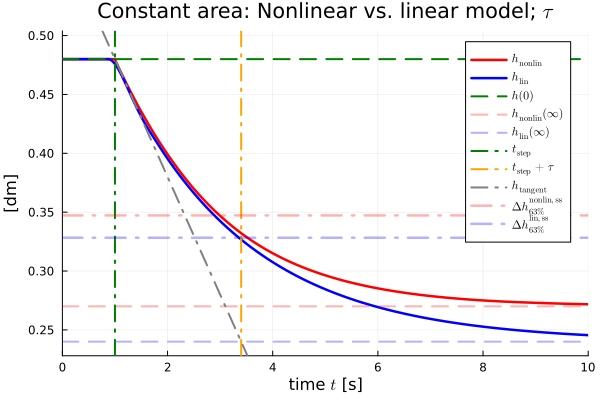

In [46]:
# Non-linear vs linear solution
plot!(t, permutedims(h_δ).+h_ss, lw=LW1, lc=LC2, label=L"h_\mathrm{lin}")
# Initial value
hline!([h_ss], lw=LW2, lc=LC3, ls=LS2, label=L"h(0)")
# Final value: nonlinear vs. linear
hline!([h_ss_], lw=LW2, lc=LC1, ls=LS2, la=LA2,label=L"h_\mathrm{nonlin}(\infty)")
hline!([h_ss + h_δ_ss_], lw=LW2, lc=LC2, ls=LS2, la=LA2,label=L"h_\mathrm{lin}(\infty)")
# Time where step takes place & step time + time constant
vline!([1], lw=LW2, lc=LC3,ls=LS3, label=L"t_\mathrm{step}")
vline!([1+τ], lw=LW2, lc=LC4,ls=LS3, label=L"t_\mathrm{step}+\tau")
# Tanget line for linear model at step
plot!(h_tangent, lw=LW2, lc=:gray,ls=LS3, label=L"h_\mathrm{tangent}")
# 63% rulers for non-linear and linear case
hline!([h_ss + (1-exp(-1))*(h_ss_-h_ss)], lw=LW1, lc=LC1,ls=LS3, la=LA2, label=L"\Delta h^\mathrm{nonlin,ss}_{63\%}")
hline!([h_ss + (1-exp(-1))*h_δ_ss_], lw=LW1, lc=LC2,ls=LS3, la=LA2, label=L"\Delta h^\mathrm{lin,ss}_{63\%}")
# Touching up with axis labels and title
plot!(xlabel=L"time $t$ [s]", ylabel = "[dm]")
plot!(title=L"Constant area: Nonlinear vs. linear model; $\tau$")
# Restricting ylims because of tangent line
plot!(ylims=((h_ss+h_δ_ss_)*0.95, h_ss*1.05))

In [47]:
if SAVEFIG
    figname = "drivenTank_Analysis"
    savefig(figpath*figname*figtype)
end
;

## Varying area tank with input - linearization

### Model

In [48]:
@parameters ρ=1 R_ς=sqrt(15/π) K=5 h_ς=3
@variables t h(t)=1.5 ṁ_i(t) ṁ_e(t) r(t) Ar(t)

ṁ(t) = ṁ_const(t)

eqs_p = [Dt(h) ~ (ṁ_i-ṁ_e)/(ρ*Ar),
        Ar ~ Num(π)*r^2,
        r ~ R_ς/h_ς*h,
        ṁ_e ~ K*sqrt(h/h_ς)]

@named tank_p = ODESystem(eqs_p)    # Partial model

eqs_i = [ṁ_i ~ ṁ(t)]
@named tank_i = ODESystem(eqs_i)    # Inputs: connecting driving functions to input variables

tank = extend(tank_i, tank_p)

Model tank_i with 5 equations
States (5):
  h(t) [defaults to 1.5]
  ṁ_e(t)
  ṁ_i(t)
  Ar(t)
⋮
Parameters (4):
  ρ [defaults to 1]
  R_ς [defaults to 2.1851]
  h_ς [defaults to 3]
  K [defaults to 5]

In [49]:
tank_simp = structural_simplify(tank)

Model tank_i with 1 equations
States (1):
  h(t) [defaults to 1.5]
Parameters (4):
  ρ [defaults to 1]
  R_ς [defaults to 2.1851]
  h_ς [defaults to 3]
  K [defaults to 5]
Incidence matrix:1×2 SparseArrays.SparseMatrixCSC{Num, Int64} with 2 stored entries:
 ×  ×

In [50]:
states(tank_simp)

1-element Vector{Any}:
 h(t)

### Finding steady state

In [51]:
tspan = (0.0,1e3)

prob = ODEProblem(tank_simp, [], tspan)
sol = solve(prob)
name_s = states(tank)
s_ss = sol(tspan[2]; idxs = name_s)
h_ss = sol(tspan[2]; idxs = h)
;

### Symbolic linearization of model

In [52]:
tank_p

Model tank_p with 4 equations
States (5):
  h(t) [defaults to 1.5]
  ṁ_e(t)
  ṁ_i(t)
  Ar(t)
⋮
Parameters (4):
  ρ [defaults to 1]
  R_ς [defaults to 2.1851]
  h_ς [defaults to 3]
  K [defaults to 5]

In [53]:
states(tank_p)

5-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 h(t)
 ṁ_e(t)
 ṁ_i(t)
 Ar(t)
 r(t)

In [54]:
u_tank = [ṁ_i]    # Indices for inputs
y_tank = [h]    # Indices for outputs

As, Bs, Cs, Ds, x_name = linearize_symbolic_dae01(eqs_p, u_tank, y_tank)
x_name

1-element Vector{Any}:
 h(t)

In [55]:
As

1×1 Matrix{Num}:
 (12.566370614359172R_ς*r(t)*ṁ_e(t)*sqrt(h(t) / h_ς) - K*Ar(t) - 12.566370614359172R_ς*r(t)*ṁ_i(t)*sqrt(h(t) / h_ς)) / (2h_ς*ρ*(Ar(t)^2)*sqrt(h(t) / h_ς))

In [56]:
Bs

1×1 Matrix{Num}:
 1 / (ρ*Ar(t))

In [57]:
Cs

1×1 Matrix{Num}:
 1.0

In [58]:
Ds

1×1 Matrix{Num}:
 0.0

### Numeric evaluation of symbolically linearized model

In [59]:
default_vals = ModelingToolkit.defaults(tank_p)

Dict{Any, Any} with 5 entries:
  R_ς  => 2.1851
  h_ς  => 3
  K    => 5
  h(t) => 1.5
  ρ    => 1

In [60]:
Asn = substitute(As, Dict(name_s .=> s_ss)) |> x -> substitute(x, default_vals) |> x -> Symbolics.unwrap.(x)

1×1 Matrix{Float64}:
 -5.425347222222794

In [61]:
Bsn = substitute(Bs, Dict(name_s .=> s_ss)) |> x -> substitute(x, default_vals) |> x -> Symbolics.unwrap.(x)

1×1 Matrix{Float64}:
 2.6041666666667878

In [62]:
Csn = substitute(Cs, Dict(name_s .=> s_ss)) |> x -> substitute(x, default_vals) |> x -> Symbolics.unwrap.(x)

1×1 Matrix{Float64}:
 1.0

In [63]:
Dsn = substitute(Ds, Dict(name_s .=> s_ss)) |> x -> substitute(x, default_vals) |> x -> Symbolics.unwrap.(x)

1×1 Matrix{Float64}:
 0.0

### Transfer Function

In [64]:
sys_sn = ss(Asn,Bsn,Csn,Dsn) |> tf

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
   2.6041666666667878
------------------------
1.0s + 5.425347222222794

Continuous-time transfer function model

### Time constant from symbolic expression

In [65]:
τ = -1/As[]

(-2h_ς*ρ*(Ar(t)^2)*sqrt(h(t) / h_ς)) / (12.566370614359172R_ς*r(t)*ṁ_e(t)*sqrt(h(t) / h_ς) - K*Ar(t) - 12.566370614359172R_ς*r(t)*ṁ_i(t)*sqrt(h(t) / h_ς))

In [66]:
substitute(τ, Dict(name_s .=> s_ss)) |> x -> substitute(x, default_vals) |> x->Symbolics.unwrap.(x)

0.18431999999998058

### Linearization using MTK

In [67]:
mats, tank_ = linearize(tank_p, [ṁ_i], [h], op=Dict(h=>h_ss, ṁ_i=>ṁ(0)))
sys = ss(mats...)

StateSpace{Continuous, Float64}
A = 
 -5.425347222222793
B = 
 2.6041666666667878
C = 
 1.0
D = 
 0.0

Continuous-time state-space model

In [68]:
[states(tank_); inputs(tank_); outputs(tank_)]

3-element Vector{Any}:
 h(t)
 ṁ_i(t)
 h(t)

In [69]:
tf(sys)

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
   2.6041666666667886
------------------------
1.0s + 5.425347222222793

Continuous-time transfer function model

### Linearization using ControlSystemsMTK

In [70]:
named_ss(tank_p, [ṁ_i], [h]; op=Dict(h=>h_ss, ṁ_i=>ṁ(0)))

NamedStateSpace{Continuous, Float64}
A = 
 -5.425347222222793
B = 
 2.6041666666667878
C = 
 1.0
D = 
 0.0

Continuous-time state-space model
With state  names: h(t)
     input  names: ṁ_i(t)
     output names: h(t)


### Time constant

In [71]:
λ = eigvals(sys.A)[]
# Timeconstant(s)

τ = 1.0/abs.(λ)

0.18431999999998058

### Plotting nonlinear & linearized model with time constant

In [72]:
ṁ(t) = ṁ_step(t)

tspan = (0.0,1e3)

prob = ODEProblem(tank_simp, [h_ss], tspan)
sol = solve(prob, QBDF())
h_ss_ = sol(tspan[2]; idxs = h)
;

In [73]:
tspan = (0.0,10)
prob = ODEProblem(tank_simp, [h_ss], tspan)
sol = solve(prob, QBDF())
#
# Non-linear solution
plot(sol, idxs=h, lw=LW1, lc=LC1, label=L"h_\mathrm{nonlin}")
;

In [74]:
# Finding linear case steady level after step
h_δ,t,x,ṁ_δ = lsim(sys, (x,t) -> [ṁ_step(t) - ṁ_step(0)], 0:0.01:1e3)
h_δ_ss_ = h_δ[end]
# Simulating linear case
h_δ,t,x,ṁ_δ = lsim(sys, (x,t) -> [ṁ_step(t) - ṁ_step(0)], 0:0.01:10)

# Tangent line
h_tangent(t) = h_ss + (t-1)*h_δ_ss_/τ
;

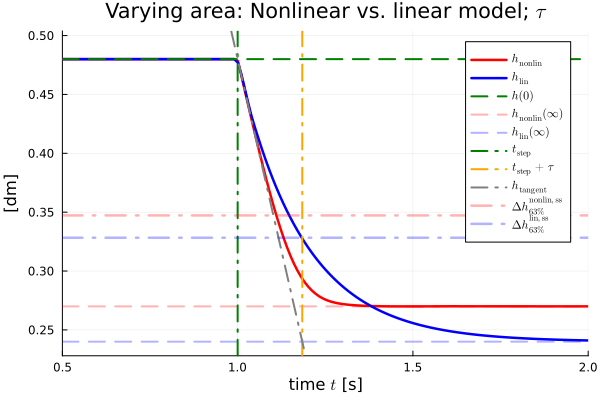

In [75]:
# Non-linear vs linear solution
plot!(t, permutedims(h_δ).+h_ss, lw=LW1, lc=LC2, label=L"h_\mathrm{lin}")
# Initial value
hline!([h_ss], lw=LW2, lc=LC3, ls=LS2, label=L"h(0)")
# Final value: nonlinear vs. linear
hline!([h_ss_], lw=LW2, lc=LC1, ls=LS2, la=LA2,label=L"h_\mathrm{nonlin}(\infty)")
hline!([h_ss + h_δ_ss_], lw=LW2, lc=LC2, ls=LS2, la=LA2,label=L"h_\mathrm{lin}(\infty)")
# Time where step takes place & step time + time constant
vline!([1], lw=LW2, lc=LC3,ls=LS3, label=L"t_\mathrm{step}")
vline!([1+τ], lw=LW2, lc=LC4,ls=LS3, label=L"t_\mathrm{step}+\tau")
# Tanget line for linear model at step
plot!(h_tangent, lw=LW2, lc=:gray,ls=LS3, label=L"h_\mathrm{tangent}")
# 63% rulers for non-linear and linear case
hline!([h_ss + (1-exp(-1))*(h_ss_-h_ss)], lw=LW1, lc=LC1,ls=LS3, la=LA2, label=L"\Delta h^\mathrm{nonlin,ss}_{63\%}")
hline!([h_ss + (1-exp(-1))*h_δ_ss_], lw=LW1, lc=LC2,ls=LS3, la=LA2, label=L"\Delta h^\mathrm{lin,ss}_{63\%}")
# Touching up with axis labels and title
plot!(xlabel=L"time $t$ [s]", ylabel = "[dm]")
plot!(title=L"Varying area: Nonlinear vs. linear model; $\tau$")
# Restricting ylims because of tangent line
plot!(ylims=((h_ss+h_δ_ss_)*0.95, h_ss*1.05), xlims=(0.5,2))

In [76]:
if SAVEFIG
    figname = "drivenFunnelTank_Analysis"
    savefig(figpath*figname*figtype)
end
;

### Testing `linearize_symbolic` for `ModelingToolkit` 

In [77]:
#=
using Pkg
Pkg.activate(temp=true)
Pkg.add("ModelingToolkit#master")
matrices, _ = ModelingToolkit.linearize_symbolic(tank_p, [ṁ_i], [h])
=#